In [1]:
from clearml import Task 

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
device = 'mps'
from tensorboardX import SummaryWriter


data_type = torch.float

In [22]:
task.close()

In [23]:
task = Task.init(project_name='Test project')
writer = SummaryWriter('runs')

ClearML Task: created new task id=e36789a4c3a54c2db1c57f4788d46327
ClearML results page: https://app.clear.ml/projects/8ded1fa7d92045e58def2b54db02e01f/experiments/e36789a4c3a54c2db1c57f4788d46327/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [24]:
def train(model, hp, data_loader, writer, debug = False):
    running_losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"], weight_decay= hp["weight_decay"])

    criterion = torch.nn.MSELoss()
    

    bar = tqdm(range(hp["epochs"]))
    for i in bar:
        epoch_loss = 0 
        for batch in data_loader:
            batch = batch.to(device)

            optimizer.zero_grad()
            pred, code = model(batch)

            batch_loss = criterion(pred,batch)
            bar.set_description(f"Loss {batch_loss}")
            '''l1_weight = 0.3
            l2_weight = 0.7
      
            # Compute L1 and L2 loss component
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * model.compute_l2_loss(torch.cat(parameters))


            batch_loss += l1
            batch_loss += l2'''
            
            if debug:
                print(f'{batch_loss=}')

            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()
        writer.add_scalar('Test/Loss', batch_loss, i)

        # Keep running track of losses
        if i % 250 == 0:
            print(f"Epoch [{i}]: " + str(epoch_loss))
    
        running_losses.append(epoch_loss)

    return model, running_losses

In [25]:
X = np.loadtxt("./data/family_data.csv", delimiter = ",")

# 0-1 Normalize the dataset
X = (X - X.min())/(X.max() - X.min())

# Transfer it to torch Tensor
X = torch.Tensor(X)

# Reshape to match the dimensions of the encoder. 
X = X.reshape(( X.shape[0], 1, -1)).to(data_type)
print(X.shape)


print(X.type())

torch.Size([9500, 1, 133])
torch.FloatTensor


In [26]:
hp = {
    "in_channels" : 1, # Number of convolutional channels, fixed to 1 for individual curves
    "channels": 10,  # 5 Number of individual channels per layer, increase to boost model capacity
    "depth": 10, # Number of Causal layers in the encoder, increase to boost model capacity
    "reduced_size" : 10, # Size to shrink final embedding to 
    "out_channels" : 10, # ^
    "kernel_size": 3, # Size of convolutional channels, 3 is the smallest to incorporate local information per time point
    "window_length": X.shape[2], # Length of input time series
    "lr": 0.001,  # Learning rate for Adam optimizer
    "epochs": 1000, # Number of training iteractions
    "batch_size": 1000,  # Number of training examples in minibatch descent, maxes at training set size
    "weight_decay":0.000 # Amount of L2 regualirzation for parameters, by default set to zero. 
}

In [27]:
from AE.model.autoencoder import Autoencoder

# Create a new model, increase precision to double floating point precision, transfer to GPU
model = Autoencoder(hp)
model.float()
model = model.to(device).to(data_type)

In [6]:

input = torch.randn(1,  1, 133)
#macs, params = profile(model, inputs=(input,))

print(f'{macs=} | {params=}')
# macs=1214388.0 | params=17026.0

NameError: name 'macs' is not defined

In [20]:
data_loader = DataLoader(X, batch_size = hp["batch_size"], )

trained_model, running_losses = train(model, hp, data_loader, writer)

Loss 0.06631564348936081:   0%|          | 1/1000 [00:01<17:03,  1.02s/it]

Epoch [0]: 0.89898981153965


Loss 0.00045704725198447704:   9%|▉         | 91/1000 [01:07<11:09,  1.36it/s]


KeyboardInterrupt: 

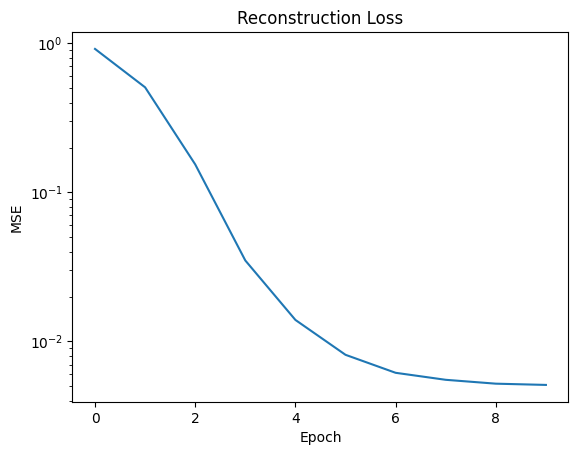

In [9]:

plt.title("Reconstruction Loss")
plt.ylabel("MSE")
plt.yscale('log')
plt.xlabel("Epoch")
plt.plot(running_losses)
plt.show()

In [10]:
# Grab the encoder and decoder
encoder = trained_model.encoder
decoder = trained_model.decoder

# Switch into evaluation mode
encoder.eval()
decoder.eval();


In [11]:
embeddings = encoder(X.to(device)).cpu().detach().numpy();
embeddings.shape

(9500, 10)

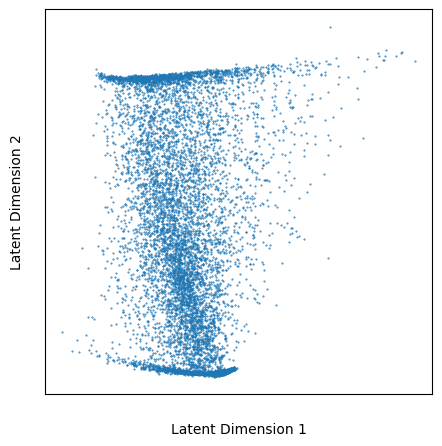

In [12]:
plt.figure(figsize = (5,5))
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left = False,
    right = False, # ticks along the top edge are off
    labelbottom=False,
    labelleft = False,
    zorder = 20) # labels along the bottom edge are off
plt.xlabel("Latent Dimension 1", labelpad= 20)
plt.ylabel("Latent Dimension 2", labelpad = 15)
plt.scatter(embeddings[:,0], embeddings[:,1], s = 0.2)
plt.show()

/var/folders/q0/lzrls2551w3btk7nl0c8dknw0000gn/T/ipykernel_76185/1435639940.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



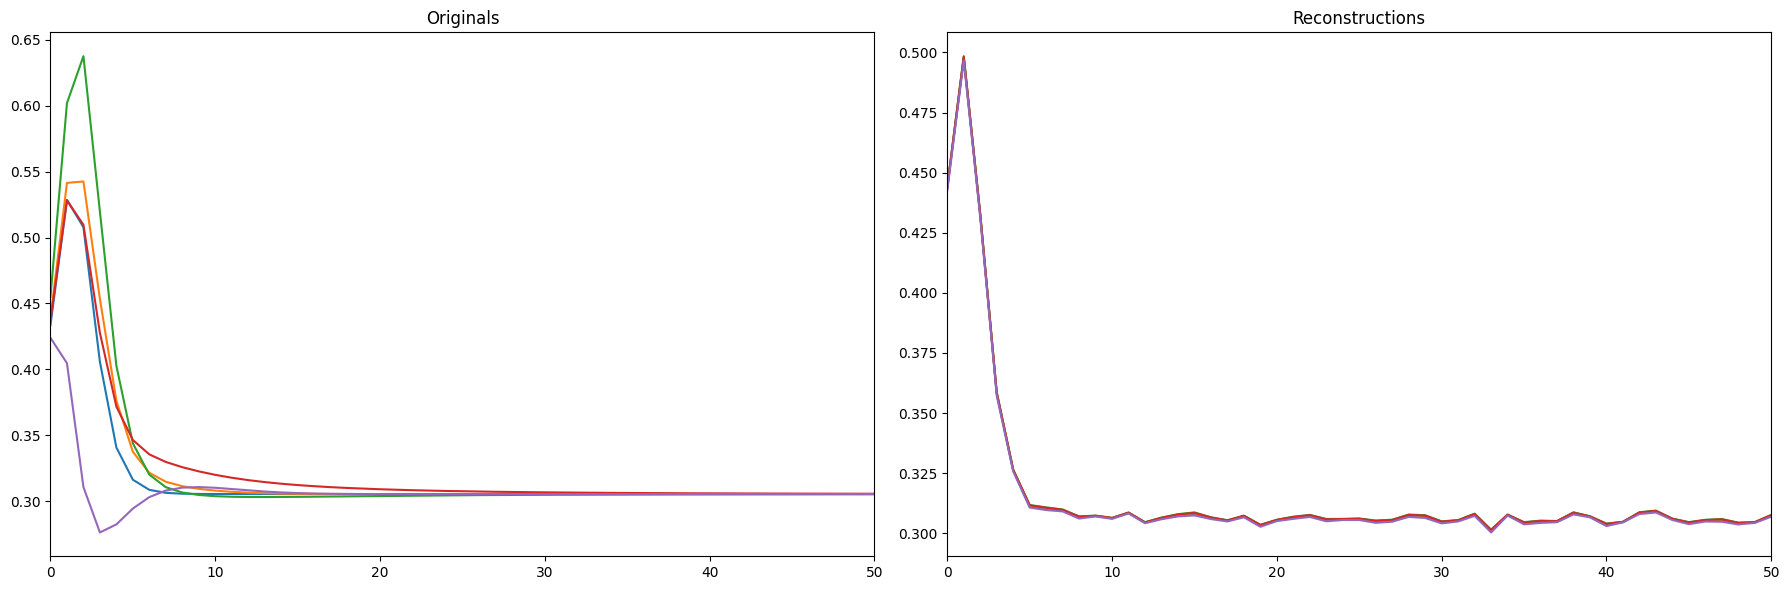

In [13]:
from matplotlib.cm import get_cmap

subset = X[np.random.randint(0,X.shape[0], size = 5), :,:].to(device)

# Generate embeddings and reconstructions
embeddings_sub = model.encoder(subset)
recons = model.decoder(embeddings_sub).cpu().detach()

# Transfer to cpu and drop gradients to enable plotting
embeddings_sub = embeddings_sub.cpu().detach()
subset = subset.cpu().detach()

fig, axs = plt.subplots(1,2, figsize = (18,6))
axs = axs.flatten()


cmap = get_cmap('tab10')  # You can change 'tab10' to any other colormap

# Plot originals
for i in range(subset.shape[0]):
    axs[0].plot(subset[i].squeeze(), color=cmap(i))
axs[0].set_title("Originals")
axs[0].set_xlim([0, 50])

# Plot reconstructions
for i in range(recons.shape[0]):
    axs[1].plot(recons[i].squeeze(), color=cmap(i))
axs[1].set_title("Reconstructions")
axs[1].set_xlim([0, 50])

plt.tight_layout()
plt.show()


'''axs[0].plot(subset.squeeze().T, color = 'red')
axs[0].set_title("Originals")
axs[0].set_xlim([0,50])
axs[1].scatter(embeddings[:,0],embeddings[:,1], color = "red")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Latent Space")


axs[2].plot(recons.squeeze().T, color = 'red')
axs[2].set_title("Reconstructions")
axs[2].set_xlim([0,50])'''


plt.show()

In [69]:
embeddings = encoder(X.to(device)).cpu()

In [70]:
from sklearn.decomposition import PCA

# Compute a PCA decomposition of the dataset
pca = PCA()
X_pca = pca.fit_transform(embeddings.detach().numpy())

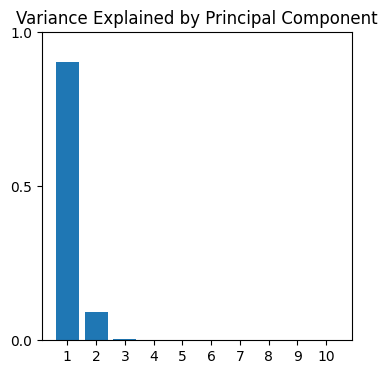

In [71]:
variances = pca.explained_variance_ratio_

# Plot formatting
plt.figure(figsize = (4,4))
plt.bar([f"{x+1}" for x in range(variances.shape[0])],height = variances)
plt.ylim(0,1.0)
plt.locator_params(axis='y', nbins=3)
plt.title("Variance Explained by Principal Component")
plt.show()

In [116]:
torch.save(model.state_dict(), './weights/fig1.pth')